In [1]:
"""""""""""""""""
Required packages
"""""""""""""""""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import random
import imageio
import cv2

In [2]:
# Importation of the dataset

data_dir = "flickr30k_images/flickr30k_images/"

df = pd.read_csv("flickr30k_images/results.csv", sep="|")

df.head(10)

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
5,10002456.jpg,0,Several men in hard hats are operating a gian...
6,10002456.jpg,1,Workers look down from up above on a piece of...
7,10002456.jpg,2,Two men working on a machine wearing hard hats .
8,10002456.jpg,3,Four men on top of a tall structure .
9,10002456.jpg,4,Three men on a large rig .


In [3]:
# Get the name of each columns

df.columns

Index(['image_name', ' comment_number', ' comment'], dtype='object')

In [50]:
# Extraction of image's filename

filename_df = df["image_name"]
filename = filename_df.values

In [51]:
# Creation of our training dataset

nb_files = len(filename) # number of images in the whole dataset
nb_dataset = 10000 # size of training data

files_image_analysis = []
compteur = 0
while compteur < nb_dataset:
    temp = random.choice(filename)
    if temp not in files_image_analysis:
        files_image_analysis.append(temp)
        compteur += 1

print(len(files_image_analysis))

print(files_image_analysis)

10000
['2733371982.jpg', '4683080278.jpg', '3286262286.jpg', '210686241.jpg', '3058361320.jpg', '4688759944.jpg', '5614228719.jpg', '4643835607.jpg', '3134387513.jpg', '560278886.jpg', '2735822661.jpg', '5010931729.jpg', '5621600104.jpg', '4655477763.jpg', '3323514651.jpg', '5438152388.jpg', '371269133.jpg', '4808742879.jpg', '4946876505.jpg', '6523865099.jpg', '3992134893.jpg', '4440605249.jpg', '2973356661.jpg', '6953343058.jpg', '473499987.jpg', '4532878470.jpg', '4530776624.jpg', '3276448136.jpg', '3994519104.jpg', '3150666056.jpg', '4449702874.jpg', '4516012575.jpg', '3490517179.jpg', '6692727651.jpg', '8116539330.jpg', '3461677493.jpg', '5669959908.jpg', '3508522093.jpg', '50159774.jpg', '136493345.jpg', '6677999435.jpg', '3184108879.jpg', '2643263887.jpg', '2775744946.jpg', '110671345.jpg', '247637795.jpg', '4850651669.jpg', '1447077067.jpg', '2954929479.jpg', '3441399292.jpg', '862683343.jpg', '462704170.jpg', '7714755346.jpg', '12648121.jpg', '298650667.jpg', '196176872.jpg', 

(500, 375, 3)

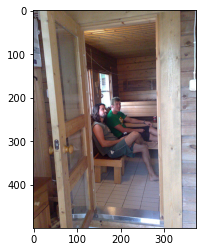

In [52]:
# Useful functions for images

def read_image(file_name):
    img_color = imageio.imread(file_name)
    return img_color

def display_image(img_in):
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return

img = read_image(data_dir+files_image_analysis[0])
display_image(img)
img.shape

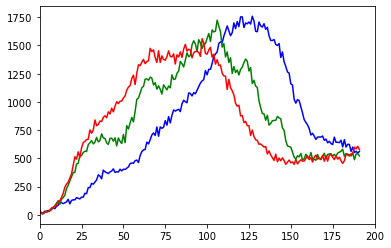

(576, 1)


In [53]:
# Test for the histogram of one image

color = ('b','g','r')
img_hist = []
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[192],[0,192])
    #histr_norm = cv2.normalize(histr, histr, norm_type=cv2.NORM_MINMAX)
    img_hist += histr.tolist() 
    plt.plot(histr,color = col)
    plt.xlim([0,200])
plt.show()

print(np.shape(img_hist))

In [54]:
# Concatenation of the 3 histograms (RGB) of each image of the dataset into one single array
# The length will be the sum of the length of each histogram 

dataset = []
for file_name in files_image_analysis:
    img = read_image(data_dir+file_name)
    img_hist = []
    for i in range(3):
        histr = cv2.calcHist([img],[i],None,[192],[0,192])
        #histr_norm = cv2.normalize(histr, histr, norm_type=cv2.NORM_MINMAX)
        img_hist += (histr.reshape(-1,1)).tolist()
    dataset.append(img_hist)

In [56]:
print(np.array(dataset)[:,:,0].shape)

(10000, 576)


In [57]:
def CAVI_update_phi(X, m, s2):
    """
    :param X: our data points
    :param m: estimated mean in the law q
    :param s2: estimated variance in the law q
    :return: the updated phi
    """
    
    first_term = X @ m.T

    second_term = - (np.linalg.norm(m, axis=1)**2 + s2.trace(axis1=-2, axis2=-1)) / 2
    second_term = second_term.reshape(1, -1)
    x = first_term + second_term
    x = x - x.max(axis=1, keepdims=True) ## avoid pb of overflow

    phi = np.exp(x)
    phi = phi / phi.sum(1, keepdims=True)
    
    return phi

def CAVI_update_mu_s2(X, phi, sigma2, K, dim):
    """
    :param X: our data points
    :param phi: estimated phi in the law q
    :param sigma2: covariance matrix of the means of the clusters
    :param K: number of clusters
    :param dim: number of dimensions of the problem
    :return: the updated m and s2
    """

    p = phi.T.sum(axis=1, keepdims=True)
    s2_inv = np.linalg.inv(sigma2) + p.reshape(-1,1)[:,:,None] * np.identity(dim)
    s2 = np.linalg.inv(s2_inv)

    a = phi.T @ X
    m  = (s2 @ a[:,:,None])[:,:,0]
    return m, s2

def elbo(X, phi, m, s2, sigma2):
    epsilon = 1e-10 
    phi += epsilon
    t1 = np.linalg.det(s2).reshape(-1,1)[:,:,None] - m[:,None,:] @ (np.linalg.inv(sigma2) @ m[:,:,None] + (np.linalg.inv(sigma2) @ s2).trace(axis1=-2, axis2=-1)[:,None,None])
    t1 = t1.sum()/2
    
    second_term = - (np.linalg.norm(m, axis=1)**2 + s2.trace(axis1=-2, axis2=-1)) / 2
    second_term = second_term.reshape(1, -1)
    second_term = (X @ m.T - np.log(phi)) + second_term

    second_term = second_term * phi
    t2 = second_term.sum()
    return t1 + t2

def CAVI_mixture_Gaussian(X, m, s2, phi, sigma2, max_iter = 500, epsilon = 1e-2):
    elbos  = [elbo(X, phi, m, s2, sigma2)]
    m_est  = [m]
    s2_est = [s2]
    phi_est = [phi]

    k, dim = phi.shape[1] , m.shape[1] 
    for it in range(1, max_iter + 1):
        phi = CAVI_update_phi(X, m, s2)
        m, s2 = CAVI_update_mu_s2(X, phi, sigma2, K, dim)
    
        m_est.append(m)
        s2_est.append(s2)
        phi_est.append(phi)

        elbos.append(elbo(X, phi, m, s2, sigma2))

        if np.abs(elbos[-2] - elbos[-1]) <= epsilon:
            break

    return elbos, m_est, s2_est, phi_est

Run the algorithm

In [58]:
K = 30 # nb of clusters
dim = 576
dataset = np.array(dataset)[:,:,0]

phi_init = np.random.dirichlet([np.random.random()*np.random.randint(1, 10)]*K, nb_dataset)
m_init = np.random.normal(0, 10, (K,dim))
s2_init = np.random.normal(0,10,(K,dim,dim))
sigma2_init = np.identity(dim)
print(phi_init.shape)
print(s2_init.shape)
print(m_init.shape)
print(sigma2_init.shape)

(10000, 30)
(30, 576, 576)
(30, 576)
(576, 576)


/Users/vincent/opt/anaconda3/lib/python3.8/site-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/vincent/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:47: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


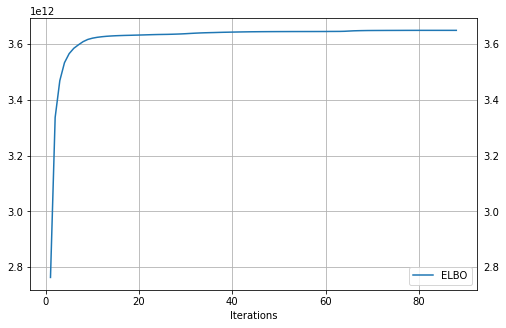

In [59]:
fig = plt.figure(figsize=(8,5))
elbos, m_est, s2_est, phi_est = CAVI_mixture_Gaussian(dataset, m_init, s2_init, phi_init, sigma2_init)
plt.plot(np.array(elbos),label = 'ELBO')
plt.tick_params(labelright=True)
plt.grid(True)
plt.xlabel('Iterations')
plt.legend();

In [60]:
print(elbos)

[nan, 2762831589809.556, 3337309331144.534, 3469603708295.1733, 3533925310279.6636, 3566360640522.9014, 3585661535746.671, 3598183367024.128, 3609571034868.9556, 3617392853368.822, 3621981480798.296, 3624987127193.6636, 3627107370365.8394, 3628697073936.7163, 3629833367365.023, 3630713048296.466, 3631348119968.3228, 3631878912291.0234, 3632282877082.7476, 3632763541409.328, 3633177896397.2974, 3633656731307.4814, 3634180940867.0425, 3634674338136.61, 3635077793168.1475, 3635365202329.7256, 3635628704420.245, 3636031275753.248, 3636573621910.6157, 3637201006259.461, 3638039351864.1963, 3639014852332.5786, 3639911351003.5396, 3640681965764.328, 3641296662357.7344, 3641737647878.475, 3642144891573.122, 3642623971542.414, 3643073517929.85, 3643404250112.029, 3643769347521.994, 3644119248147.751, 3644389585647.6533, 3644656530319.6646, 3644918424994.144, 3645070707072.999, 3645209151883.652, 3645336233559.968, 3645426743657.6006, 3645520872941.6323, 3645580472840.0415, 3645625942183.2686, 3

In [61]:
m_est[-1]

array([[  433.37532134,   208.81748072,   185.27249357, ...,
          244.25449871,   246.781491  ,   247.56298201],
       [  694.04532164,   347.43128655,   333.96491228, ...,
          283.15350877,   280.75292398,   282.52192982],
       [40549.73611111, 10432.73611111,  5647.15277778, ...,
          132.27777778,   129.55555556,   123.05555556],
       ...,
       [ 3444.31896552,  2245.37931034,  1949.52586207, ...,
          170.63362069,   168.7887931 ,   169.43534483],
       [13982.65625   , 28706.46875   , 20349.71875   , ...,
           98.75      ,    95.        ,    96.75      ],
       [  921.49120879,   433.37692308,   356.81428571, ...,
          709.20769231,   720.26923077,   736.07912088]])

In [64]:
s2_est[-1]

array([[[0.00257069, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.00257069, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.00257069, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00257069,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.00257069, 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.00257069]],

       [[0.00146199, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.00146199, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.00146199, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00146199,
         0.        , 0.        ],
        [0. 

In [66]:
# Get the cluster of each images

list_clusterisation = phi_est[-1].argmax(axis=1)   
print(list_clusterisation)

[19  1 21 ... 21  7 13]


In [67]:
# Storage of each image in the cluster that belongs to it

list_cluster_image = [[] for k in range(K)]

for idx, cluster in enumerate(list_clusterisation) :
    list_cluster_image[cluster].append(files_image_analysis[idx])

print(list_cluster_image)

#for i in range(K):
#    for k in range(nb_dataset):
#        if list_clusterisation[k,i] == 1:
#            list_cluster_image[i].append(files_image_analysis[k])

[['560278886.jpg', '5621600104.jpg', '3994519104.jpg', '6915121934.jpg', '3196995975.jpg', '1078621572.jpg', '486720042.jpg', '472396131.jpg', '2980348138.jpg', '4067191572.jpg', '2050067751.jpg', '717673249.jpg', '3683974620.jpg', '7711989162.jpg', '3561433412.jpg', '4242041141.jpg', '8008558496.jpg', '2875583266.jpg', '3122888809.jpg', '6204719881.jpg', '422736619.jpg', '143552697.jpg', '7278854458.jpg', '431410325.jpg', '4360907086.jpg', '460781612.jpg', '5070190270.jpg', '4452063256.jpg', '248858242.jpg', '2257294002.jpg', '448590900.jpg', '2215837479.jpg', '3827227200.jpg', '3595216998.jpg', '2345980168.jpg', '500290283.jpg', '2287023569.jpg', '3249891130.jpg', '358770558.jpg', '2839532455.jpg', '4811271229.jpg', '6179362236.jpg', '3526461098.jpg', '4717521897.jpg', '2860314714.jpg', '7632424360.jpg', '264483970.jpg', '256292144.jpg', '359837950.jpg', '7371731720.jpg', '3489014985.jpg', '3816820298.jpg', '1147391743.jpg', '3553434575.jpg', '1384302953.jpg', '6157574915.jpg', '1713

In [68]:
# Check the population of each clusters

for k in range(K):
    print(len(list_cluster_image[k]))

388
683
71
5
916
500
239
1474
96
280
429
38
351
397
637
194
82
129
989
415
318
906
0
0
83
36
82
231
31
0


Cluster n°0
388
Cluster n°1
683
Cluster n°2
71
Cluster n°4
916
Cluster n°5
500
Cluster n°6
239
Cluster n°7
1474
Cluster n°8
96
Cluster n°9
280
Cluster n°10
429
Cluster n°11
38


<ipython-input-69-7de95166a7d2>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(3,3)


Cluster n°12
351
Cluster n°13
397
Cluster n°14
637
Cluster n°15
194
Cluster n°16
82
Cluster n°17
129
Cluster n°18
989
Cluster n°19
415
Cluster n°20
318
Cluster n°21
906
Cluster n°24
83
Cluster n°25
36
Cluster n°26
82
Cluster n°27
231
Cluster n°28
31


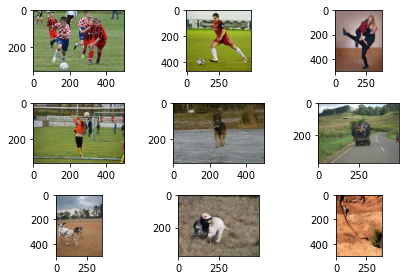

<Figure size 1080x720 with 0 Axes>

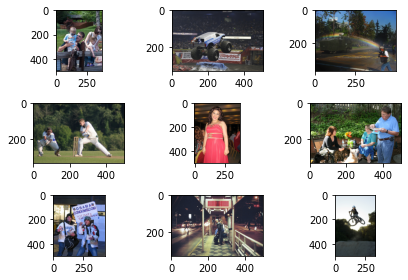

<Figure size 1080x720 with 0 Axes>

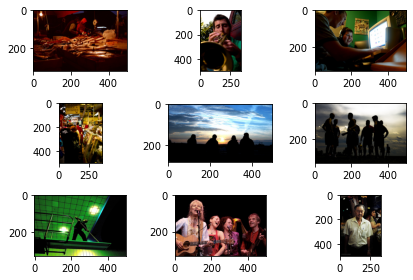

<Figure size 1080x720 with 0 Axes>

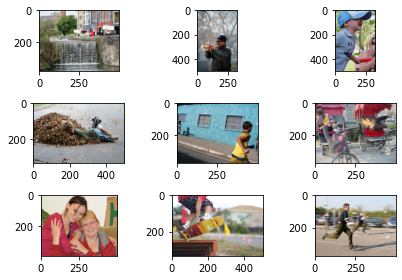

<Figure size 1080x720 with 0 Axes>

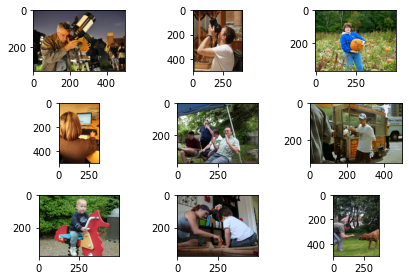

<Figure size 1080x720 with 0 Axes>

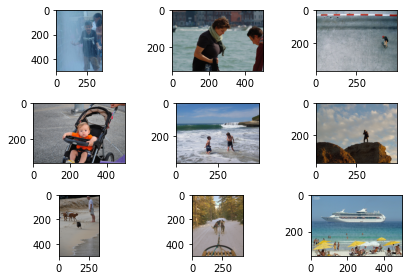

<Figure size 1080x720 with 0 Axes>

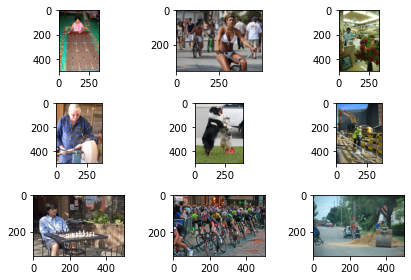

<Figure size 1080x720 with 0 Axes>

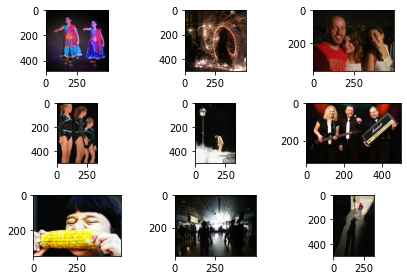

<Figure size 1080x720 with 0 Axes>

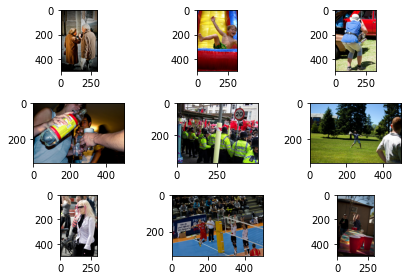

<Figure size 1080x720 with 0 Axes>

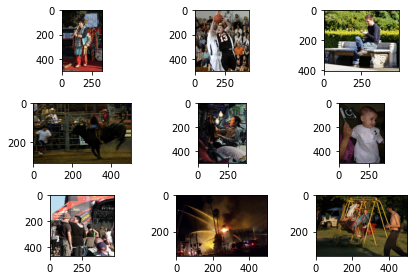

<Figure size 1080x720 with 0 Axes>

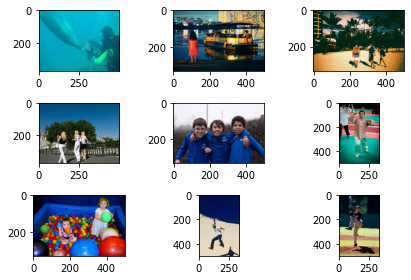

<Figure size 1080x720 with 0 Axes>

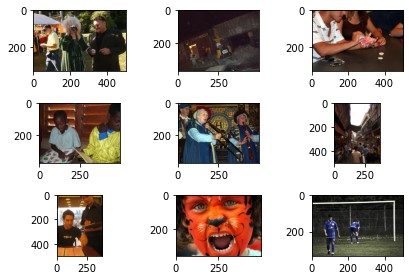

<Figure size 1080x720 with 0 Axes>

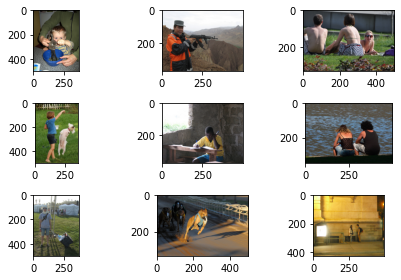

<Figure size 1080x720 with 0 Axes>

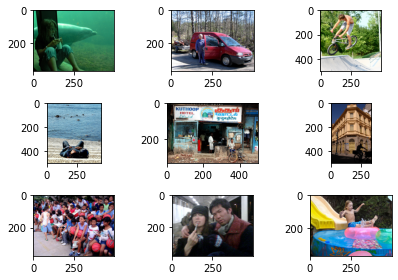

<Figure size 1080x720 with 0 Axes>

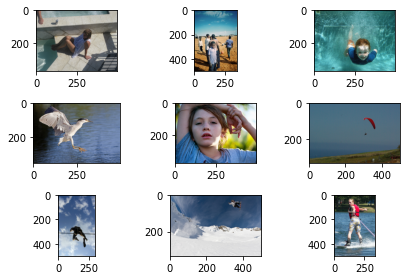

<Figure size 1080x720 with 0 Axes>

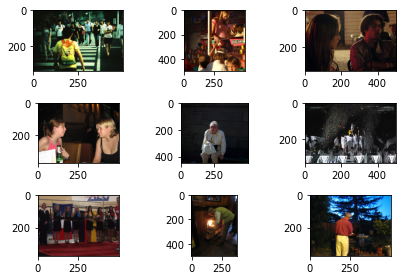

<Figure size 1080x720 with 0 Axes>

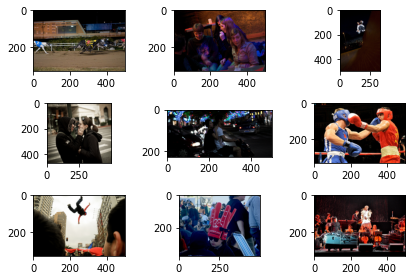

<Figure size 1080x720 with 0 Axes>

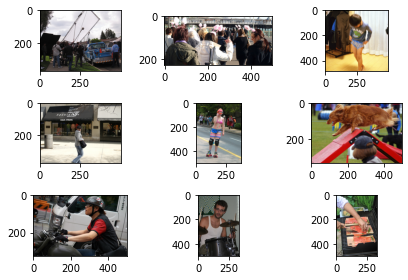

<Figure size 1080x720 with 0 Axes>

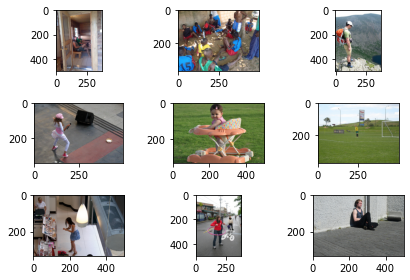

<Figure size 1080x720 with 0 Axes>

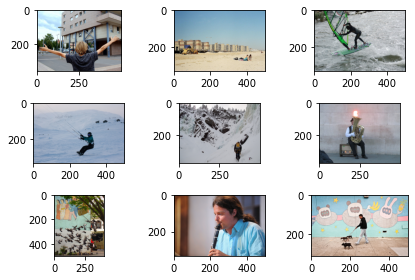

<Figure size 1080x720 with 0 Axes>

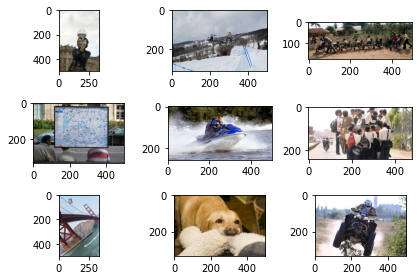

<Figure size 1080x720 with 0 Axes>

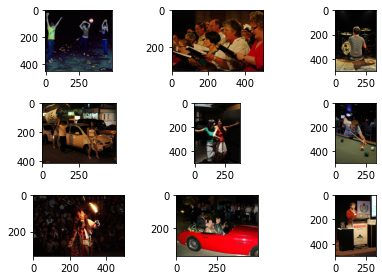

<Figure size 1080x720 with 0 Axes>

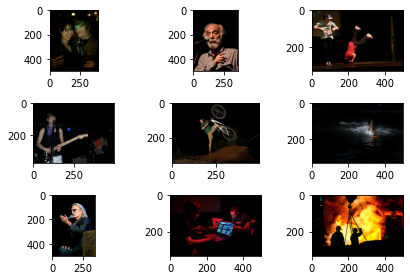

<Figure size 1080x720 with 0 Axes>

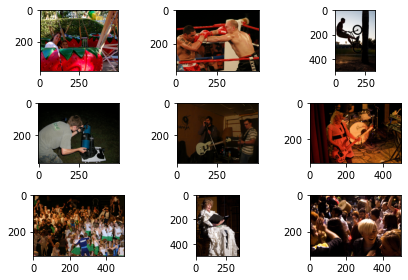

<Figure size 1080x720 with 0 Axes>

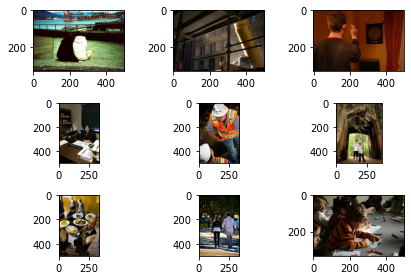

<Figure size 1080x720 with 0 Axes>

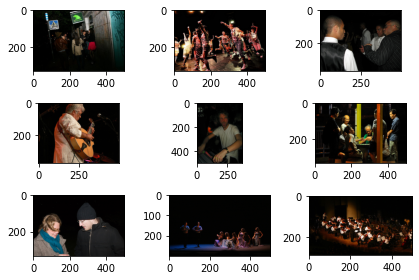

<Figure size 1080x720 with 0 Axes>

In [69]:
# Plot images of each clusters

for k in range(K):
    cluster = list_cluster_image[k]
    
    if len(cluster) >= 9 :
        print("Cluster n°" + str(k))
        print(len(cluster))

        f, axarr = plt.subplots(3,3)
        plt.figure(figsize=(15, 10)) 

        axarr[0,0].imshow(read_image(data_dir+cluster[0]))
        axarr[0,1].imshow(read_image(data_dir+cluster[1]))
        axarr[0,2].imshow(read_image(data_dir+cluster[2]))
        axarr[1,0].imshow(read_image(data_dir+cluster[3]))
        axarr[1,1].imshow(read_image(data_dir+cluster[4]))
        axarr[1,2].imshow(read_image(data_dir+cluster[5]))
        axarr[2,0].imshow(read_image(data_dir+cluster[6]))
        axarr[2,1].imshow(read_image(data_dir+cluster[7]))
        axarr[2,2].imshow(read_image(data_dir+cluster[8]))

        f.tight_layout()

